---
title: 02 Canny Edge Detection
description: Learning Canny through python 
authors:
  - name: Ryan E Lima
    orcid: 0000-0002-5352-7215
---

## Install Packages

In [1]:
#!pip install numpy opencv-python rasterio matplotlib
#!pip install requests

## Load Libraries

In [2]:
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
import requests
import os
import math
import itertools

In [3]:
# URL of the DEM
DEM_URL = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n35w112/USGS_1_n35w112_20240402.tif'
dem_path = 'Data/USGS_1_n35w112_20240402.tif'  # Local filename

In [4]:
# Download the DEM if it doesn't exist locally
if not os.path.exists(dem_path):
    print("Downloading DEM...")
    response = requests.get(DEM_URL, stream=True)
    with open(dem_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("Download complete.")

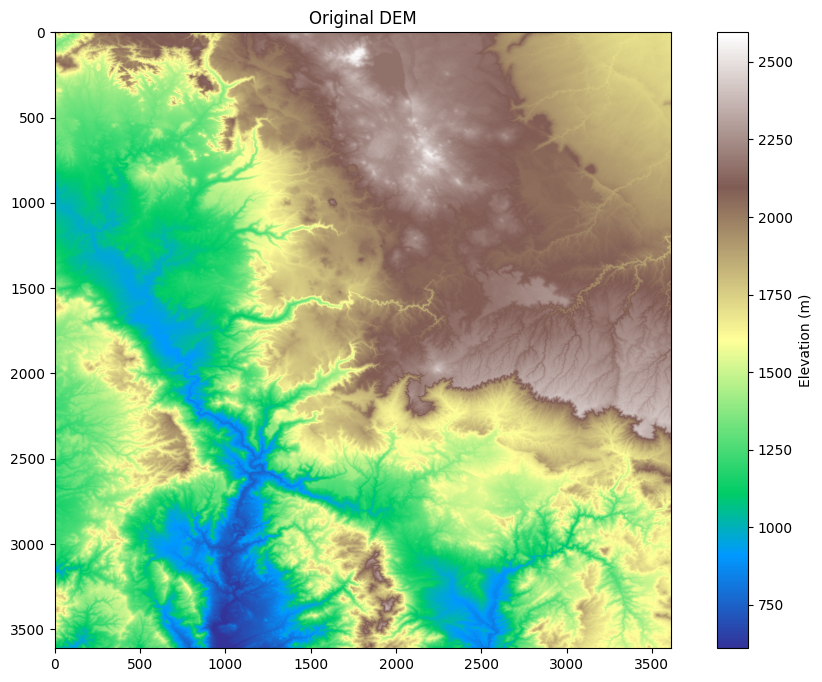

In [5]:
# Load DEM using rasterio
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Read the first band (assuming a single-band DEM)
    profile = src.profile  # Save profile to ensure consistent georeferencing
    transform = src.transform

# Step 1: Original DEM
plt.figure(figsize=(12, 8))
plt.title("Original DEM")
plt.imshow(dem, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.show()

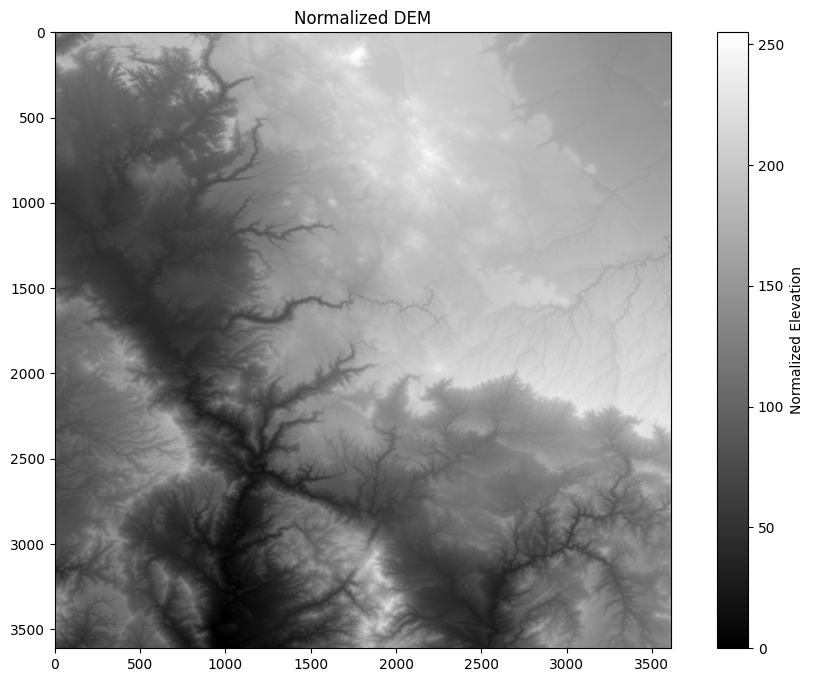

In [6]:
# Normalize the DEM for better edge detection
dem_normalized = cv2.normalize(dem, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Step 2: Normalized DEM
plt.figure(figsize=(12, 8))
plt.title("Normalized DEM")
plt.imshow(dem_normalized, cmap='gray')
plt.colorbar(label='Normalized Elevation')
plt.show()

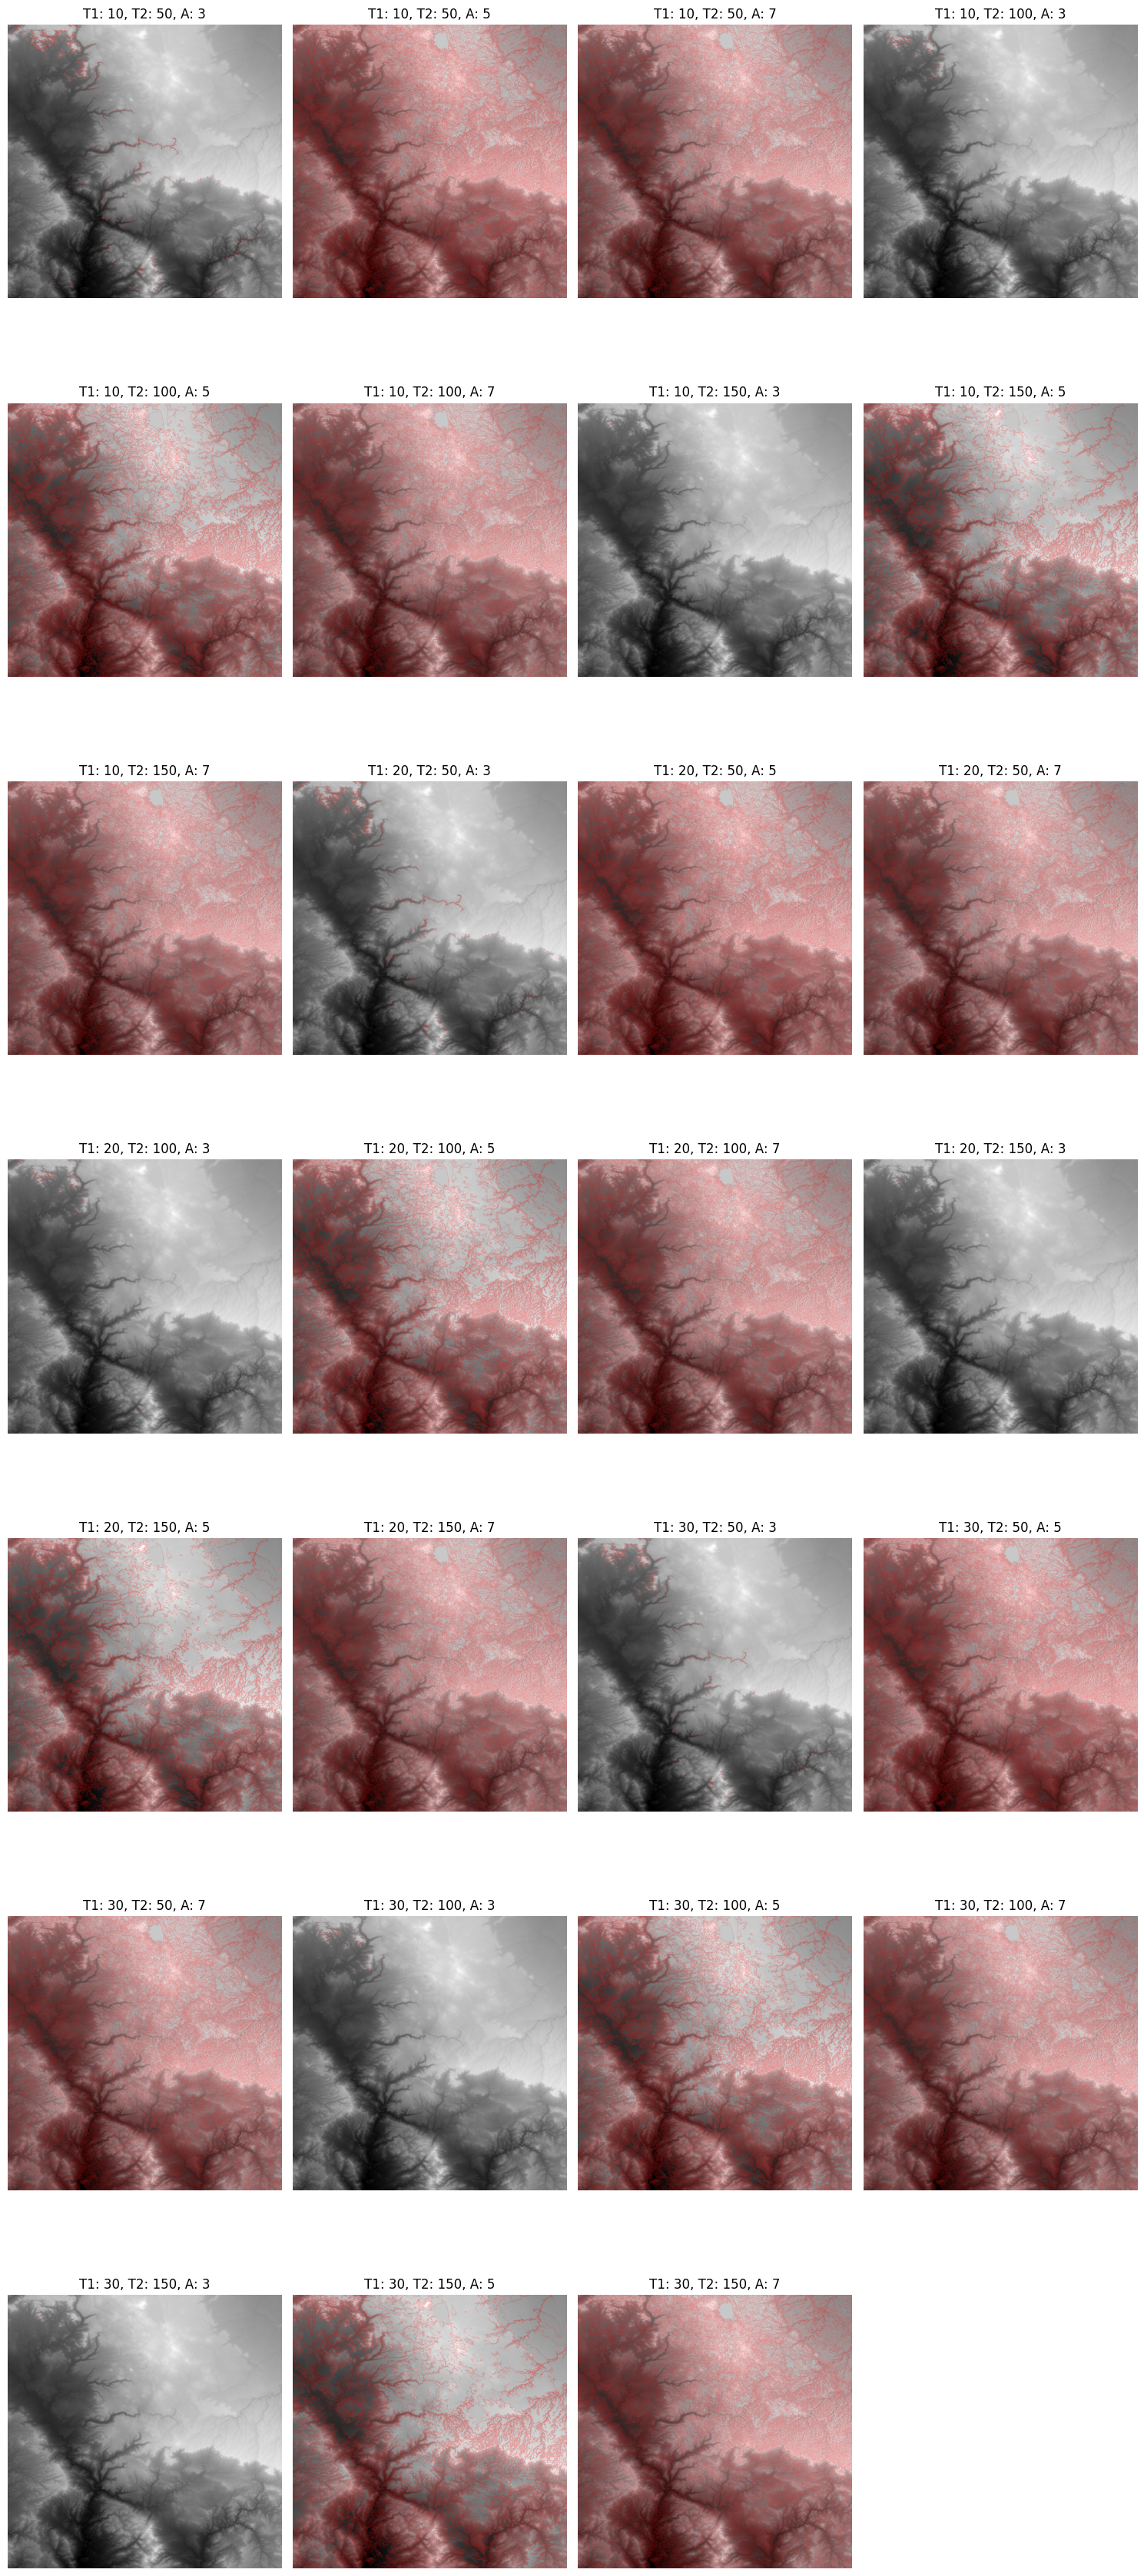

In [7]:
# Define parameter ranges for Canny edge detection
threshold1_values = [10, 20, 30]  # Lower thresholds for gradient intensity
threshold2_values = [50, 100, 150]  # Upper thresholds for gradient intensity
aperture_sizes = [3, 5, 7]  # Kernel sizes for Sobel operator

# Prepare parameter combinations
parameter_combinations = list(itertools.product(threshold1_values, threshold2_values, aperture_sizes))

# Function to apply Canny edge detection and overlay edges on DEM
def apply_canny_overlay(image, dem_normalized, threshold1, threshold2, aperture_size):
    edges = cv2.Canny(image, threshold1, threshold2, apertureSize=aperture_size)
    
    # Create a color version of the DEM
    dem_colored = cv2.cvtColor(dem_normalized, cv2.COLOR_GRAY2BGR)
    
    # Overlay edges in red
    dem_colored[edges > 0] = [255, 0, 0]  # Red color for edges
    return dem_colored

# Dynamically determine subplot grid size
num_combinations = len(parameter_combinations)
cols = 4  # Number of columns in subplot grid
rows = (num_combinations // cols) + (num_combinations % cols > 0)

plt.figure(figsize=(15, 5 * rows))  # Adjust figure size based on rows

# Apply Canny for each combination and plot results
for i, (threshold1, threshold2, aperture_size) in enumerate(parameter_combinations):
    result = apply_canny_overlay(dem_normalized, dem_normalized, threshold1, threshold2, aperture_size)
    
    plt.subplot(rows, cols, i + 1)
    plt.title(f'T1: {threshold1}, T2: {threshold2}, A: {aperture_size}')
    plt.imshow(result)
    plt.axis('off')

plt.tight_layout()
plt.show()

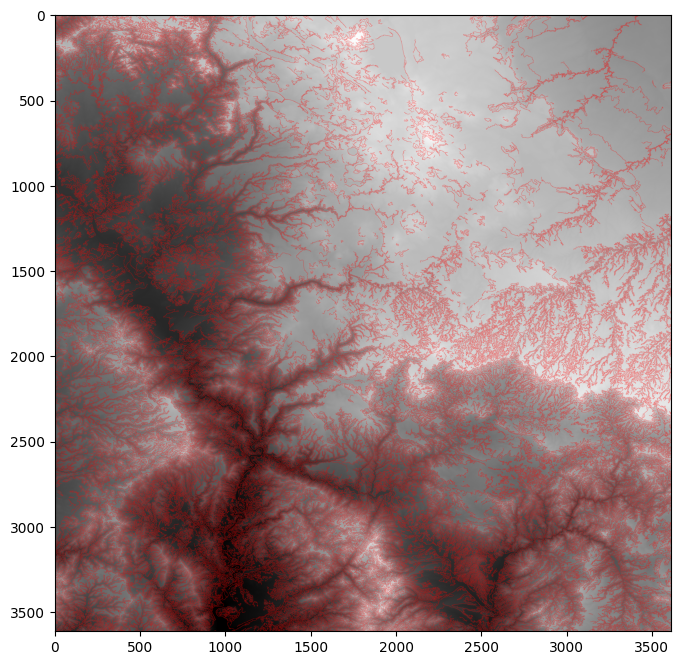

In [8]:
# Good combinations: [30,150,5],[20,150,5][10,150,5]
threshold1 =30
threshold2 =150
aperture_size =5 


Canny_edges = apply_canny_overlay(dem_normalized, dem_normalized, threshold1, threshold2, aperture_size)
Cedges = cv2.Canny(dem_normalized, threshold1, threshold2, apertureSize=aperture_size)
plt.figure(figsize=(12, 8))
plt.imshow(Canny_edges)
plt.show()

In [10]:
# Update the profile for the Canny edge output
profile.update(
    dtype=rasterio.uint8,  # Edge images are typically binary or 8-bit
    count=1,  # Single-band output
    compress='lzw',  # Optional compression
    nodata=None  # Remove or set a valid nodata value for uint8
)

# Ensure CRS and transform are carried over
print(f"CRS of input DEM: {profile['crs']}")
print(f"Transform of input DEM: {profile['transform']}")

# Save the Canny edges as GeoTIFF with the same CRS and transform
canny_output_path = 'Data/Canny_edges_geotiff_new.tif'
with rasterio.open(canny_output_path, 'w', **profile) as dst:
    dst.write(Cedges, 1)  # Write Canny edges as the first band
print(f"Canny edge GeoTIFF saved to {canny_output_path}")

CRS of input DEM: EPSG:4269
Transform of input DEM: | 0.00, 0.00,-112.00|
| 0.00,-0.00, 35.00|
| 0.00, 0.00, 1.00|
Canny edge GeoTIFF saved to Data/Canny_edges_geotiff_new.tif


In [14]:
# Save the Canny edges as a PNG
canny_output_path = 'Data/Canny_edges_new.png'  # Path for the PNG export
cv2.imwrite(canny_output_path, Cedges)  # Corrected: first argument is the path, second is the image
print(f"Image saved to {canny_output_path}")

Image saved to Data/Canny_edges_new.png


In [ ]:
# Parameter ranges to optimize
rho_values = [1, 2, 3]  # Distance resolution in pixels
threshold_values = [50, 100, 150]  # Minimum votes for a line
min_line_length_values = [20, 50, 100]  # Minimum line segment length
max_line_gap_values = [5, 10, 20]  # Maximum gap between line segments

# Prepare for grid search
parameter_combinations = list(itertools.product(rho_values, threshold_values, min_line_length_values, max_line_gap_values))

# Function to apply Probabilistic Hough Transform and visualize results
def apply_hough_transform(Cedges, rho, theta, threshold, min_line_length, max_line_gap):
    cedgesP = cv2.cvtColor(Cedges, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored output
    linesP = cv2.HoughLinesP(Cedges, rho, theta, threshold, None, min_line_length, max_line_gap)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(cedgesP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 2, cv2.LINE_AA)  # Red color (BGR: (0, 0, 255))
    return cedgesP

# Dynamically determine subplot grid size
num_combinations = len(parameter_combinations)
cols = 4  # Number of columns in subplot grid
rows = (num_combinations // cols) + (num_combinations % cols > 0)

plt.figure(figsize=(15, 5 * rows))  # Adjust figure size based on rows

# Plot all combinations
for i, (rho, threshold, min_line_length, max_line_gap) in enumerate(parameter_combinations):
    result = apply_hough_transform(Cedges, rho, np.pi/180, threshold, min_line_length, max_line_gap)
    
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Rho: {rho}, Thresh: {threshold}\nMinLen: {min_line_length}, MaxGap: {max_line_gap}')
    plt.imshow(result)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Probabilistic Hough Transform with chosen parameters
rho = 3  # Distance resolution in pixels
theta = np.pi / 180  # Angular resolution in radians
threshold = 100  # Minimum number of votes
min_line_length = 20  # Minimum line length
max_line_gap = 10  # Maximum gap between line segments


result = apply_hough_transform(Cedges, rho, np.pi/180, threshold, min_line_length, max_line_gap)
plt.figure(figsize=(10, 10))
plt.title(f'Rho: {rho}, Thresh: {threshold}\nMinLen: {min_line_length}, MaxGap: {max_line_gap}')
plt.imshow(result)
plt.axis('off')
plt.tight_layout()
plt.show()



In [ ]:
# Save the output image
output_path = 'Data\detected_lineaments.png'  # Use .tif for GeoTIFF export
cv2.imwrite(output_path, line_image)
print(f"Image saved to {output_path}")

# Optional: Export as GeoTIFF with georeferencing
output_geotiff_path = 'Data\detected_lineaments_geotiff.tif'
with rasterio.open(output_geotiff_path, 'w', **profile) as dst:
    # Save only the red channel (detected lines) for georeferencing
    red_channel = line_image[:, :, 2]
    dst.write(red_channel, 1)
print(f"GeoTIFF saved to {output_geotiff_path}")